# Heart Failure Prediction - IA01 Project Autumn 2025
# UTT - Introduction to Artificial Intelligence
 
This notebook contains the exploratory data analysis, data preprocessing, 
and machine learning modeling steps for predicting heart failure. 
The dataset used combines multiple sources including Cleveland, Hungarian, 
Switzerland, Long Beach VA, and Stalog datasets, resulting in 918 observations 
after removing duplicates.

The goal is to analyze the dataset, identify important features, 
train several classification models (kNN, Decision Tree, Random Forest, 
Logistic Regression, Neural Networks), and evaluate their performance.


# We import important libraries to analyze the dataset
 

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer

# Helpers

In [33]:
def hist_box(feature, data):
    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    sns.histplot(x=feature, data=data)
    plt.subplot(1,2,2)
    sns.boxplot(y=feature, data=data)
    plt.tight_layout()
    plt.show()

In [34]:
def IQR(feature, data):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# Start of EDA


## Data preparation

### General dataframe information

In [35]:
heart_data = pd.read_csv('../data/heart.csv')
print(f"In our dataset we have {heart_data.shape[0]} rows and {heart_data.shape[1]} columns\n")
print(heart_data.head())

In our dataset we have 918 rows and 12 columns

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [36]:
print("\nDataset info:")
print(heart_data.info())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


### Conversion of data to catergorial and numerical types

In [37]:
# Categorical data conversion
# category type consume less memort than an object type, because it stores only the unique categoruies and uses links to represnt them in the columns 
cat_cols = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
for c in cat_cols:
    heart_data[c] = heart_data[c].astype('category')

# Numeric data conversion
# to verify that all values are numeric and convert non-numeric values to NaN
num_cols = ['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']
for c in num_cols:
    heart_data[c] = pd.to_numeric(heart_data[c], errors='coerce')  # non-numeric -> NaN
    
heart_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    int64   
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    int64   
dtypes: category(5), float64(1), int64(6)
memory usage: 55.5 KB


In [38]:
print("\nDataset numerical discription:\n")
print(heart_data.describe())


Dataset numerical discription:

              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000  


### Checking for missing values

In [39]:
heart_data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [40]:
heart_data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

The dataset doesn't contain __NaN__ or __Null__ values

### Checking for dublicates

In [41]:
print(heart_data.duplicated().sum())

0


The dataset doesn't contain __duplicates__

## Descriptive Statistics 

In [44]:
heart_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Exploratory Data Analysis: Univariate Overview

The dataset contains **918 observations** of 7 numerical features related to patients’ health metrics and heart disease diagnosis:

- **Age**: Age of the patient (years)  
- **RestingBP**: Resting blood pressure (mm Hg)  
- **Cholesterol**: Serum cholesterol level (mg/dl)  
- **FastingBS**: Fasting blood sugar (1 if >120 mg/dl, else 0)  
- **MaxHR**: Maximum heart rate achieved  
- **Oldpeak**: ST depression induced by exercise relative to rest  
- **HeartDisease**: Target variable (1: presence of heart disease, 0: absence)  

---

### Initial Observations from Summary Statistics

#### 1. Missing Values
- All columns have `count = 918`, which matches the total number of rows.
- No missing values are reported in this summary.
- **Note:** Some columns may have invalid zero values that could represent missing or erroneous measurements.

#### 2. Strange or Outlier Values
- **RestingBP**: Minimum = 0 → physiologically impossible; likely **missing or erroneous**.  
- **Cholesterol**: Minimum = 0 → unlikely; may indicate **missing values coded as 0**.  
- **Oldpeak**: Minimum = -2.6 → unusual, possibly **data entry errors**.  
- Other columns (`Age`, `MaxHR`, `FastingBS`, `HeartDisease`) appear within plausible ranges.

#### 3. Distributions and Skewness
- **Age**: Mean ~53.5, range 28–77 → slightly right-skewed (more middle-aged patients).  
- **RestingBP**: Mean ~132 mm Hg, skewed due to zero values.  
- **Cholesterol**: Wide range (0–603 mg/dl) → includes invalid zeros, highly right-skewed.  
- **Oldpeak**: Mean ~0.89, max = 6.2, min = -2.6 → indicates potential outliers.  
- **FastingBS**: Binary; majority (77%) have normal fasting blood sugar (0).  
- **HeartDisease**: Binary; roughly balanced (55% with disease, 45% without).

---

### Columns Requiring Attention
1. **RestingBP** and **Cholesterol**: Check and handle zero values; treat as missing if appropriate.  
2. **Oldpeak**: Investigate negative values; possible data entry errors.  
3. **FastingBS & HeartDisease**: Binary variables; check distribution and balance.

---

### Conclusion
- Most variables are numerical and suitable for statistical analysis.
- Some features have **suspicious or extreme values** (`RestingBP=0`, `Cholesterol=0`, `Oldpeak<0`) that need to be addressed before modeling.
- Categorical variables (`Sex`, `ChestPainType`, `RestingECG`, `ExerciseAngina`, `ST_Slope`) should be analyzed for **distribution, missing values, and category balance**.
- Overall, the dataset is relatively clean in terms of row counts, but careful attention is required for **data quality and outliers**.


### Univariate Analysis (Numerical values)

In [46]:
numeric_features = heart_data.select_dtypes(include='number').columns.tolist()

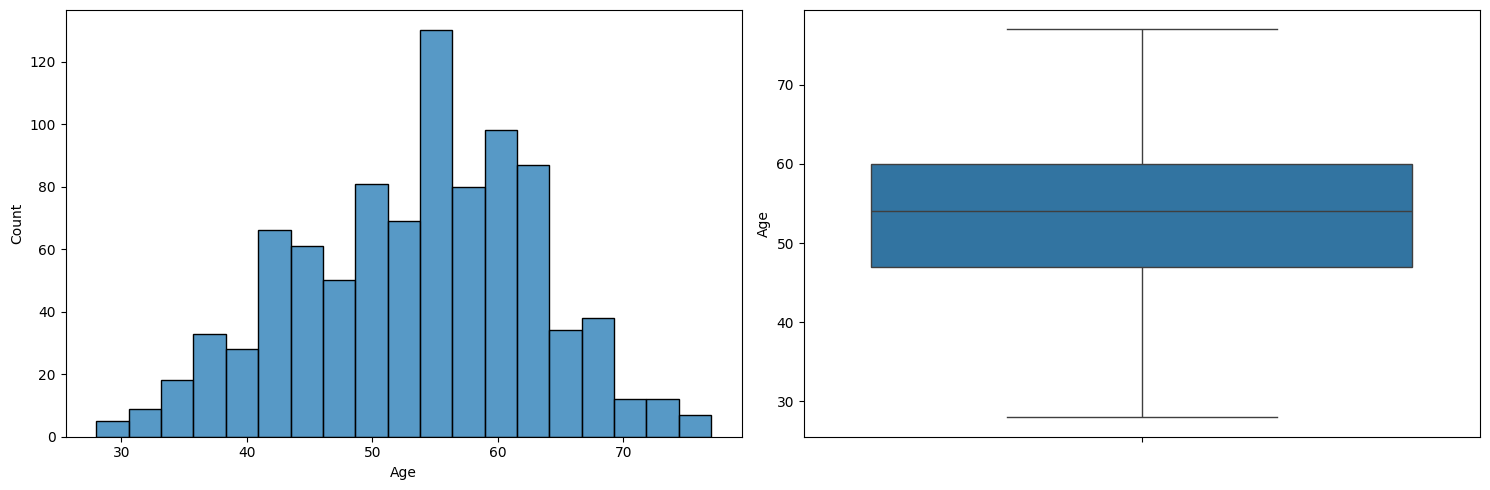

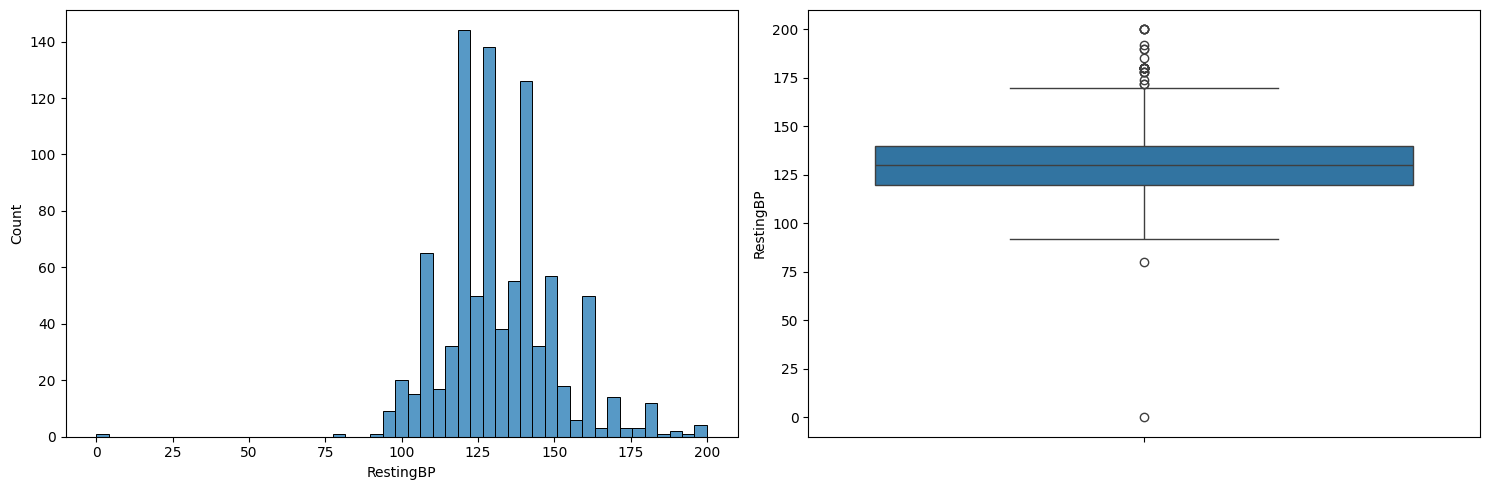

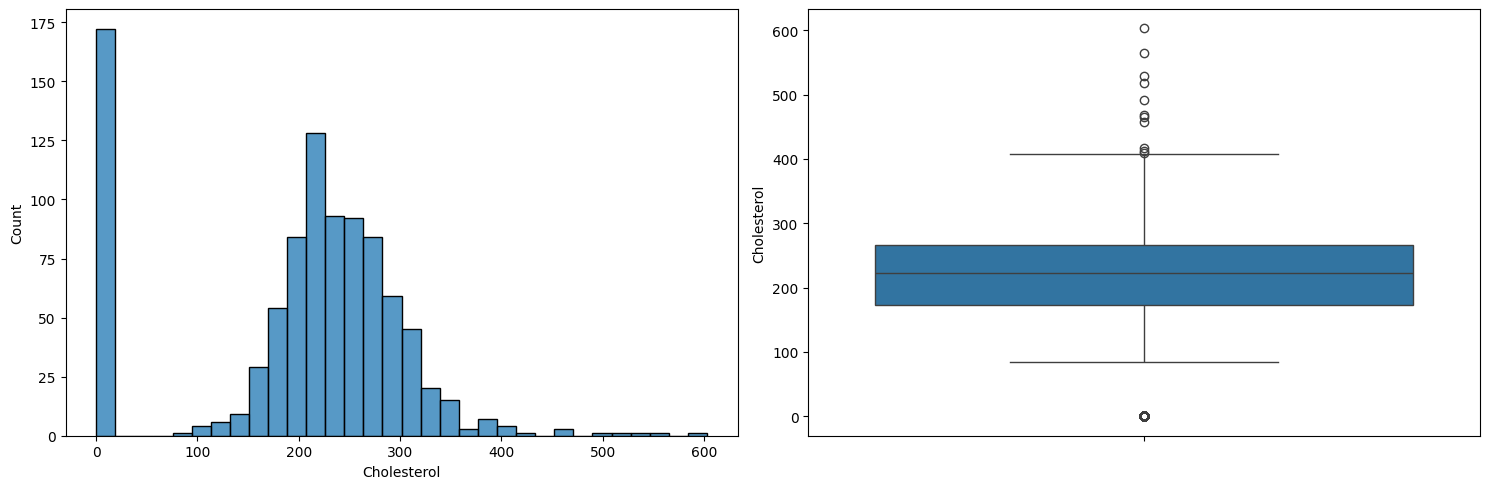

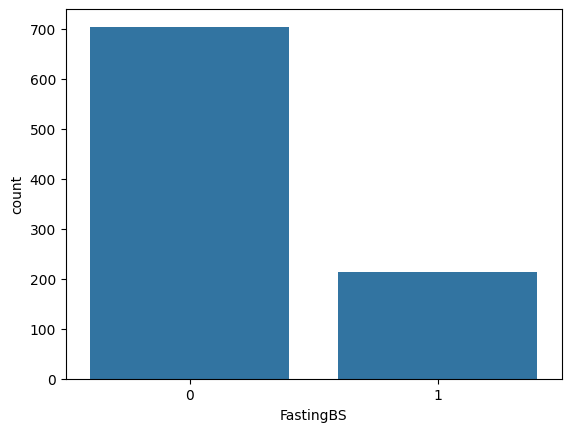

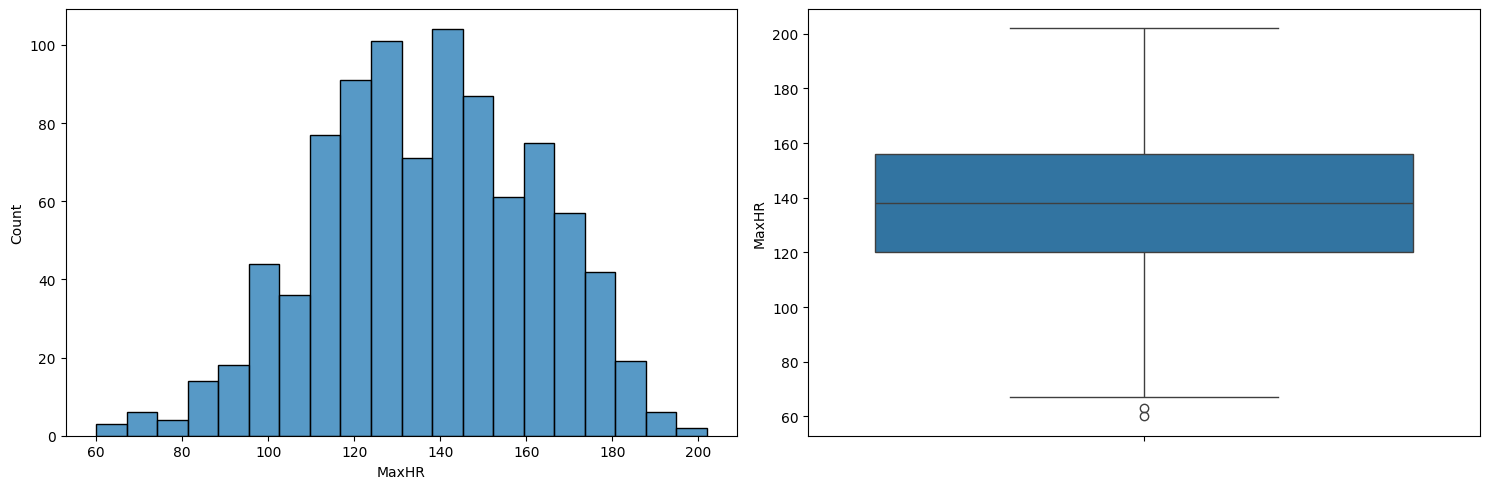

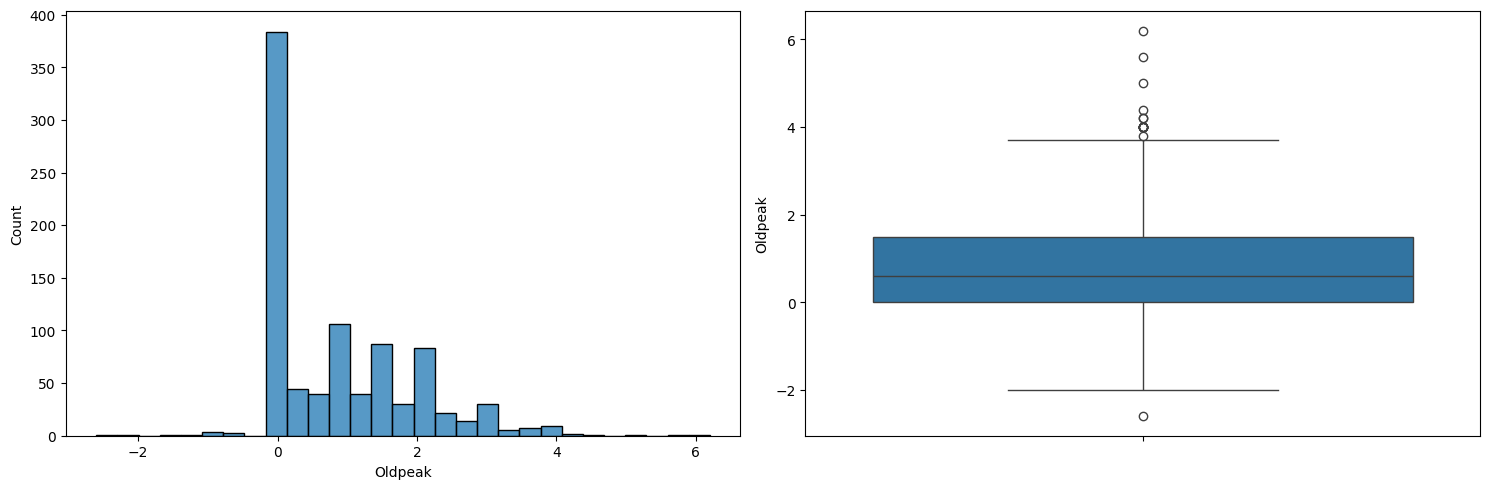

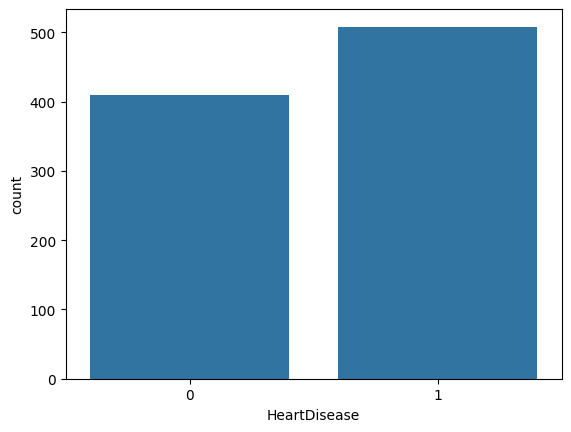

In [50]:
for feature in numeric_features:
    if feature in ['FastingBS', "HeartDisease"]:
        sns.countplot(x=feature, data=heart_data)
    else:
        hist_box(feature, heart_data)

- `Age`
    - The histogram shows that Age is approximately normally distributed, with most patients between **45 and 65 years old**, which is typical for a heart-disease-focused dataset. The boxplot indicates a relatively symmetric distribution with no extreme outliers, suggesting that Age is a clean and reliable feature. Overall, the population is predominantly middle-aged to older adults, aligning with known risk groups for heart disease.
- `RestingBP`
    - The histogram for RestingBP shows a roughly centered distribution around **120–140 mmHg**, which is consistent with typical resting blood pressure ranges in adults. A single value at **0 mmHg** appears in both the histogram and boxplot, which is physiologically impossible and indicates an erroneous or missing measurement. The boxplot also reveals several high outliers above **170 mmHg**, likely representing hypertensive patients rather than data errors.
- `Choresterol`
    - The histogram shows a large spike at **0 mg/dl**, which is medically impossible and indicates erroneous or missing cholesterol values that must be corrected. Among valid measurements, cholesterol follows a right-skewed distribution centered around **200–260 mg/dl**, with several high outliers above **400 mg/dl**. The boxplot confirms both the invalid zero values and the presence of clinically plausible high-cholesterol outliers.
- `FastingBS`
    - The bar plot shows that most patients have a fasting blood sugar value of **0**, meaning normal glucose levels, while a smaller portion (around 20–25%) have elevated fasting blood sugar (value **1**). This reflects the expected distribution in a general or clinical population, where high fasting sugar is less common. Because FastingBS is a binary variable, no outliers or unusual patterns are present.
- `MaxHR`
    - The histogram shows that MaxHR is mostly concentrated between **120 and 160 bpm**, forming an approximately bell-shaped distribution typical for exercise stress testing. A small number of very low values, such as **60 bpm**, appear in the boxplot and represent unusual or clinically concerning cases, possibly due to incomplete exercise tests or severe cardiac limitations. Overall, the feature looks clean but contains a few physiologically extreme low outliers worth noting.
- `Oldpeak`
    - The histogram shows that Oldpeak is heavily right-skewed, with the majority of values clustered at 0, indicating no ST depression during exercise, while higher values up to **6** represent more severe abnormalities. The boxplot highlights several high outliers above **4**, which likely correspond to patients with significant cardiac stress responses. A few negative values also appear, which can occur due to ECG baseline shifts, but they remain rare and should be kept in mind during preprocessing.
- `HeartDisease`
    - The target variable is fairly balanced, with slightly more patients labeled as having heart disease **(1)** than not **(0)**. This moderate class imbalance should not cause major issues during model training but may still benefit from stratified train–test splitting. Overall, the distribution indicates that the dataset contains sufficient examples of both classes for effective classification modeling.

### Univariate Analysis (Categorial values)

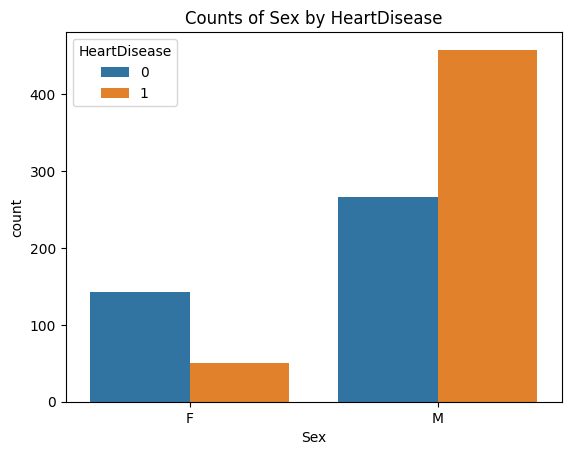

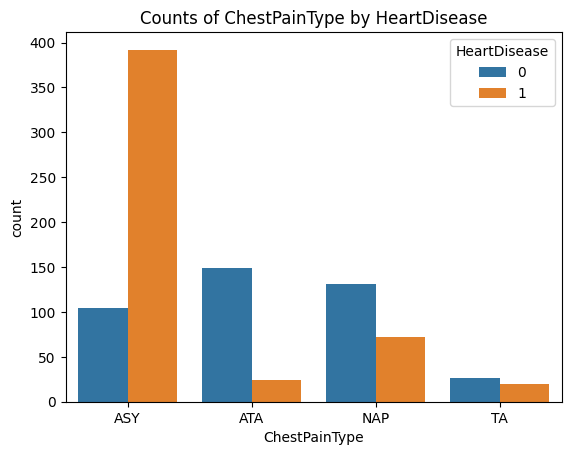

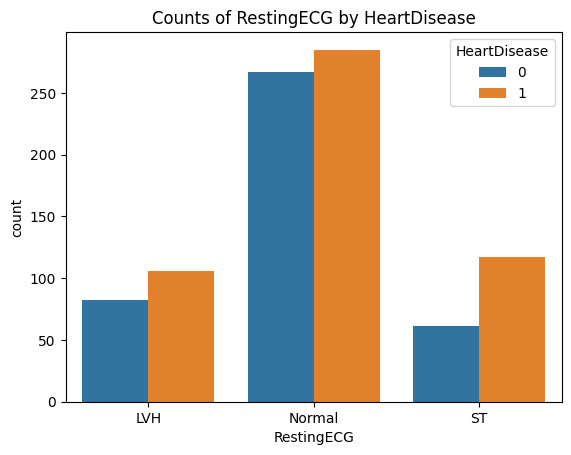

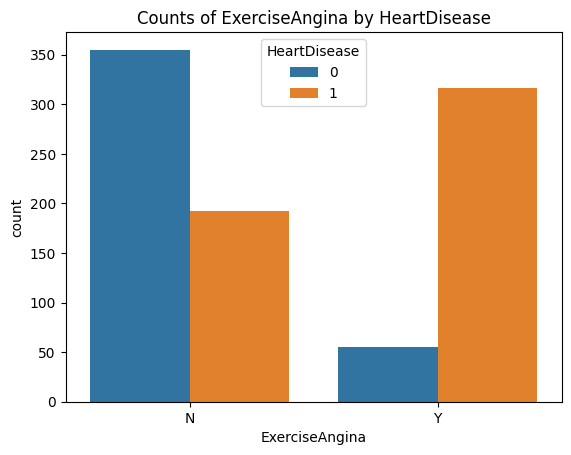

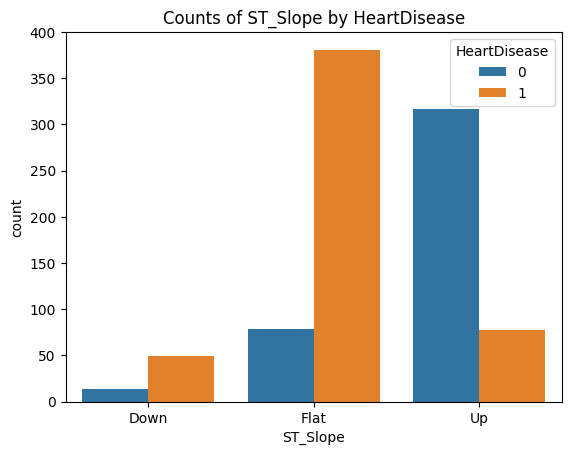

In [55]:
for feature in cat_cols:
    #print(f"\nValue counts for {feature}:\n", heart_data[c].value_counts())
    sns.countplot(x=feature, hue='HeartDisease', data=heart_data)
    plt.title(f"Counts of {feature} by HeartDisease")
    plt.show()

    